# Using EcoFOCIpy to process raw field data

**Cruise DY2104 ()

**Processed by Shaun Bell**

## CTD / Profile Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- SBE workflow must happen first **done (performed on seperate windows system to convert to cnv)**
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added.  Good for quick analysis

Other than hosting on an erddap server, the above can be done at sea

For furthur processing, QC and archiving, the following tasks are to be done *(working or final data level)*:
- Add metadata from cruise yaml files created from cast logs
- apply any calibrations or corrections
    + field corrections
    + offsets
    + spike analysis
    + some QC were available... this would be old-school simple bounds mostly
- save as CF netcdf via xarray or potentially csv file: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is (can be csv as this is useful at sea)
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- TSSigma, TOXYChlor, TurbParTrans


In [27]:
import yaml
import glob

import ecofocipy.io.sbe_ctd_parser as sbe_ctd_parser #<- instrument specific
import ecofocipy.io.ncCFsave as ncCFsave
import ecofocipy.metaconfig.load_config as load_config
import ecofocipy.math.geotools as geotools

## At Sea NRT Processing

In [28]:
sample_data_dir = '/Users/bell/ecoraid/2021/CTDcasts/dy2104/' #root path to cruise directory
ecofocipy_dir = '/Users/bell/Programs/EcoFOCIpy/'

In [29]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2104' #no hyphens
inst_meta_file = sample_data_dir+'logs/FOCI_oneoxy_CTD.yaml'
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

In [30]:
#this line adds available NMEA data to csv files for NRT/Preliminary erddap hosting... if there isn't an NMEA string, you will have to pull the locations
#  from the cast logs and output either a .nc or a more elaborate csv file furthur in to this process
NMEA_location = True
verbose = False

if NMEA_location:
    
    for cast in cruise_header.keys():
        cruise_data[cast][['time','latitude','longitude','profileid']] = ('0',0,0,'0')
        cruise_data[cast][['time','latitude','longitude','profileid']] = (cruise_header[cast]['NMEAtime'],
              geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[0],
              geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[1],
              cast.split('.')[0])
        if verbose:
            print(cruise_header[cast]['NMEAtime'],
                  geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[0],
                  geotools.latlon_convert(cruise_header[cast]['NMEALat'],cruise_header[cast]['NMEALon'])[1])

In [31]:
#save downcast csv to file for viewing - really this is just a cleaned up cnv file
import pandas as pd
for cast in cruise_data.keys():
#     print(f'Processing Cast {cast}')
    cruise_data[cast]['time'] = pd.to_datetime(cruise_data[cast]['time'])
    cruise_data[cast].to_csv(sample_data_dir+cast.replace('cnv','csv'))

# Post Cruise Processing with additional meta information

In [32]:
###############################################################
# edit to point to {cruise sepcific} raw datafiles 
datafile = sample_data_dir+'rawconverted/' #<- point to cruise and process all files within
cruise_name = 'DY2104' #no hyphens
cruise_meta_file = sample_data_dir+'logs/DY2104.yaml'
inst_meta_file = sample_data_dir+'logs/FOCI_oneoxy_CTD.yaml'
group_meta_file = ecofocipy_dir+'staticdata/institutional_meta_example_ctd.yaml'
inst_shortname = '' #keep as placeholder for now
###############################################################

#init and load data
cruise = sbe_ctd_parser.sbe9_11p()
filename_list = sorted(glob.glob(datafile + '*.cnv'))

(cruise_data,cruise_header) = cruise.parse(filename_list)

## Time Properties

Not traditionally dealt with for CTD files as they are likely dynamically updated via GPS feed.  However, FOCI tends to label the date/time with the ***at depth*** time-stamp

## Depth Properties and other assumptions

- currently, all processing and binning (1m for FOCI) is done via seabird routines and the windows software.  This may change with the python ctd package for a few tasks

## Load all external meta information

In [42]:
#cruise info
with open(cruise_meta_file) as file:
    cruise_config = yaml.full_load(file)

#instrument info
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

#institutional info
with open(group_meta_file) as file:
    group_config = yaml.full_load(file)

In [43]:
inst_config

{'time': {'epic_key': 'TIM_601',
  'name': 'time',
  'generic_name': 'time',
  'standard_name': 'time',
  'long_name': 'date and time since reference time'},
 'depth': {'epic_key': 'D_3',
  'generic_name': 'depth',
  'units': 'meter',
  'long_name': 'depth below surface (meters)',
  'standard_name': 'depth',
  'positive': 'down'},
 'latitude': {'epic_key': 'LON_501',
  'name': 'latitude',
  'generic_name': 'latitude',
  'units': 'degrees_north',
  'long_name': 'latitude',
  'standard_name': 'latitude'},
 'longitude': {'epic_key': 'LAT_500',
  'name': 'longitude',
  'generic_name': 'longitude',
  'units': 'degrees_east',
  'long_name': 'longitude',
  'standard_name': 'longitude'},
 'temperature_ch1': {'epic_key': 'T_28',
  'generic_name': 'temp channel 1',
  'long_name': 'Sea temperature in-situ ITS-90 scale',
  'standard_name': 'sea_water_temperature',
  'units': 'degree_C'},
 'temperature_ch2': {'epic_key': 'T2_35',
  'generic_name': 'temp channel 2',
  'long_name': 'Sea temperature i

In [44]:
cruise_config['CTDCasts']['CTD001']

{'id': 53859,
 'Vessel': 'NOAAS Oscar Dyson',
 'CruiseID': 'DY2104',
 'Project_Leg': '',
 'UniqueCruiseID': 'DY2104',
 'Project': 'MACE Summer Pollock',
 'StationNo_altname': '1',
 'ConsecutiveCastNo': 'CTD001',
 'LatitudeDeg': 57,
 'LatitudeMin': 37.98,
 'LongitudeDeg': 152,
 'LongitudeMin': 24.43,
 'GMTDay': 2,
 'GMTMonth': 'Jun',
 'GMTYear': 2021,
 'GMTTime': 5816,
 'DryBulb': -99.9,
 'RelativeHumidity': -999,
 'WetBulb': -99.9,
 'Pressure': -9999,
 'SeaState': '',
 'Visibility': '',
 'WindDir': -999,
 'WindSpd': -99.9,
 'CloudAmt': '',
 'CloudType': '',
 'Weather': '',
 'SurfaceTemp': -99.9,
 'BottomDepth': -9999,
 'StationNameID': '',
 'MaxDepth': -9999,
 'InstrumentSerialNos': '',
 'Notes': '',
 'NutrientBtlNiskinNo': '',
 'NutrientBtlNumbers': '',
 'OxygenBtlNiskinNo': '',
 'OxygenBtlNumbers': '',
 'SalinityBtlNiskinNo': '',
 'SalinityBtlNumbers': '',
 'ChlorophyllBtlNiskinNo': '',
 'ChlorophyllBtlVolumes': '',
 'InstrumentType': 'SBE911plus',
 'WaterMassCode': '',
 'isMooringPr

In [45]:
cruise_data['ctd001.cnv'].columns

Index(['c0mS/cm', 'c1mS/cm', 'chlor_fluorescence', 'sbeox0V',
       'temperature_ch1', 'temperature_ch2', 'timeS', 'turbidity',
       'salinity_ch1', 'salinity_ch2', 'sigma_t_ch1', 'sigma_t_ch2',
       'oxy_concM_ch1', 'oxy_conc_ch1', 'oxy_percentsat_ch1', 'nbin', 'flag'],
      dtype='object')

In [46]:
for cast in cruise_data.keys():
    print(f'Processing Cast {cast}')
    try:
        #output cruise cast stats here
        #cruise_data[cast].describe()
        #cruise_data['ctd001.cnv'].hist() - seaborn may have a better summary plot than just a bunch of histograms
        #sns.pairplot(cruise_data[cast])

        cruise_data[cast] = cruise_data[cast].rename(columns={
                            't090C':'temperature_ch1',
                            't190C':'temperature_ch2',
                            'sal00':'salinity_ch1',
                            'sal11':'salinity_ch2',
                            'sbox0Mm/Kg':'oxy_conc_ch1',
                            'sbeox0ML/L':'oxy_concM_ch1',
                            'sbeox0PS':'oxy_percentsat_ch1',
                            'sbox1Mm/Kg':'oxy_conc_ch2',
                            'sbeox1ML/L':'oxy_concM_ch2',
                            'sbeox1PS':'oxy_percentsat_ch2',
                            'sigma-t00':'sigma_t_ch1',
                            'sigma-t11':'sigma_t_ch2',
                            'flECO-AFL':'chlor_fluorescence',
                            'turbWETntu0':'turbidity',
                            'par':'par',
                            'empty':'empty', #this will be ignored
                            'flag':'flag'})

        cruise_data[cast].index.rename('depth',inplace=True)
        #cruise_data[cast].sample()

        cruise_data_nc = ncCFsave.EcoFOCI_CFnc(df=cruise_data[cast], 
                                    instrument_yaml=inst_config, 
                                    operation_yaml=cruise_config,
                                    operation_type='ctd')
        cruise_data_nc.expand_dimensions(dim_names=['latitude','longitude','time'],geophys_sort=False)
        cruise_data_nc.variable_meta_data(variable_keys=list(cruise_data[cast].columns.values),drop_missing=True)
        cruise_data_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])
        cruise_data_nc.temporal_geospatioal_meta_data_ctd(positiveE=False,conscastno=cast.split('.')[0])

        cruise_data_nc.var_qcflag_init(dim_names=['depth','latitude','longitude','time'])

        #interp to sfc for list of vars
        cruise_data_nc.interp2sfc(novars=['par'])

        #add global attributes
        cruise_data_nc.deployment_meta_add(conscastno=cast.upper().split('.')[0])
        cruise_data_nc.get_xdf()

        #add instituitonal global attributes
        cruise_data_nc.institution_meta_add(group_config)

        #add creation date/time - provenance data
        cruise_data_nc.provinance_meta_add()

        #provide intial qc status field
        cruise_data_nc.qc_status(qc_status='unknown')

        cast_label = cast.split('.')[0].split('d')[-1]
        cruise_data_nc.xarray2netcdf_save(xdf = cruise_data_nc.get_xdf(),
                                filename=sample_data_dir+cruise_name+'c'+cast_label.zfill(3)+'_ctd.nc',format="NETCDF3_CLASSIC")
        #generate editable csv files
        to_edit = True
        if to_edit:
            if not cast[0] in ['d','u']: #dont save editable up and downcast files, just nc files for plotting... all u/d files can be removed after final data
                cruise_data_nc.get_xdf().to_dataframe().to_csv(sample_data_dir+cruise_name+'c'+cast_label.zfill(3)+'_ctd.to_edit.csv')  
        
    except:
       print('Conversion Failed')

Processing Cast ctd001.cnv
Processing Cast ctd002.cnv
Processing Cast ctd003.cnv
Processing Cast ctd004.cnv
Processing Cast ctd005.cnv
Processing Cast ctd006.cnv
Processing Cast ctd007.cnv
Processing Cast ctd008.cnv
Processing Cast ctd009.cnv
Processing Cast ctd010.cnv
Processing Cast ctd011.cnv
Processing Cast ctd012.cnv
Processing Cast ctd013.cnv
Processing Cast ctd014.cnv
Processing Cast ctd015.cnv
Processing Cast ctd016.cnv
Processing Cast ctd017.cnv
Processing Cast ctd018.cnv
Processing Cast ctd019.cnv
Processing Cast ctd020.cnv
Processing Cast ctd021.cnv
Processing Cast ctd022.cnv
Processing Cast ctd023.cnv
Processing Cast ctd024.cnv
Processing Cast ctd025.cnv
Processing Cast ctd026.cnv
Processing Cast ctd027.cnv
Processing Cast ctd028.cnv
Processing Cast ctd029.cnv
Processing Cast ctd030.cnv
Processing Cast ctd031.cnv
Processing Cast dctd001.cnv
Conversion Failed
Processing Cast dctd002.cnv
Conversion Failed
Processing Cast dctd003.cnv
Conversion Failed
Processing Cast dctd004.c

## Range Check

In [47]:
range_summary = pd.DataFrame()

for cast in cruise_data.keys():
    if (not cast.startswith('u')) and (not cast.startswith('d')):
        cast_range = cruise_data[cast].describe().loc[['min','max']][['chlor_fluorescence','temperature_ch1', 'temperature_ch2','turbidity', 
                                                                      'salinity_ch1', 'salinity_ch2','oxy_percentsat_ch1']]
        cast_range['cast'] = cast
        range_summary = pd.concat([range_summary,cast_range],ignore_index=True)


In [48]:
pd.set_option('display.max_rows', None)

def make_pretty(styler):
    styler.background_gradient(axis=0, cmap="YlGnBu_r")
    return styler

range_summary.style.pipe(make_pretty)

,chlor_fluorescence,temperature_ch1,temperature_ch2,turbidity,salinity_ch1,salinity_ch2,oxy_percentsat_ch1,cast
0,0.234700,4.669000,4.669100,0.186100,30.953000,30.899900,91.020000,ctd001.cnv
1,2.215300,7.352700,7.320800,0.873500,31.825400,31.826900,124.760000,ctd001.cnv
2,0.093500,5.223900,5.224400,0.069100,32.078800,32.080500,90.403000,ctd002.cnv
3,0.949200,6.835000,6.834400,0.198500,32.409600,32.410600,105.398000,ctd002.cnv
4,0.070100,4.788000,4.788200,0.021700,32.168200,32.168700,78.893000,ctd003.cnv
5,8.217400,7.082300,7.083400,0.194200,32.672700,32.672400,114.115000,ctd003.cnv
6,0.131200,5.828000,5.828300,0.191800,31.870200,31.870800,96.964000,ctd004.cnv
7,0.569800,5.967700,5.967900,0.312200,32.104400,32.104900,99.182000,ctd004.cnv
8,0.188000,5.277100,5.277400,0.062800,31.988400,31.989400,95.194000,ctd005.cnv
9,3.282000,6.503500,6.503500,0.271500,32.149900,32.150400,108.380000,ctd005.cnv


## QC Next Steps

In [49]:
import ecofocipy.plots.sbe_ctd_plots as sbe_ctd_plots
import os
import xarray as xa
import seaborn as sns
import numpy as np

In [55]:
sample_data_dir = '/Users/bell/ecoraid/2021/CTDcasts/dy2104/working/' #root path to cruise directory working repo

### QC of data (plot parameters with other instruments)
- be sure to updated the qc_status for the file and the history for future steps
- from NRT csv files... make edits then use that to modify netcdf?
- **Better Yet** export netcdf files with variable flags to csv and edit then reingest and modify
    - modify netcdf in place and provide a qcflag?


### Likely first edits
- research issues noted in cruise logs
- remove failed instrument (clogs, or other challenges that arent correctable)
- extrapolate to sfc (not par though)
- despike depths (interpolate between depths)
- check for common issues
    - lags in salinity when going through interface

Profile Averaged Salinity DY2103c001_ctd.nc Difference,STD (chan1-chan2)0.00595000000000009,0.020841853495859257
Profile Averaged Salinity DY2103c002_ctd.nc Difference,STD (chan1-chan2)-0.0010172727272727787,0.0004965076381194338
Profile Averaged Salinity DY2103c003_ctd.nc Difference,STD (chan1-chan2)-0.000745637583892811,0.0010123720050993002
Profile Averaged Salinity DY2103c004_ctd.nc Difference,STD (chan1-chan2)-0.0005489583333334602,0.0004254886386231401
Profile Averaged Salinity DY2103c005_ctd.nc Difference,STD (chan1-chan2)-0.0004489583333328791,0.0004968640809421269
Profile Averaged Salinity DY2103c006_ctd.nc Difference,STD (chan1-chan2)-0.0003999999999999688,0.0007206076340968894
Profile Averaged Salinity DY2103c007_ctd.nc Difference,STD (chan1-chan2)-0.0007062500000003524,0.0008854509797271834
Profile Averaged Salinity DY2103c008_ctd.nc Difference,STD (chan1-chan2)-0.00034193548387081264,0.0004750376511724193
Profile Averaged Salinity DY2103c009_ctd.nc Difference,STD (chan1-ch

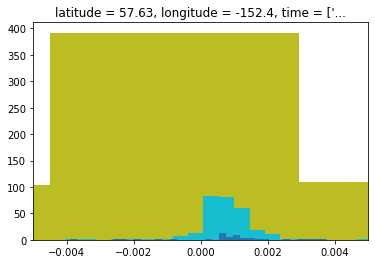

In [57]:
#test for salinity bottle run needs
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        saldiff = cruise_data_nc.salinity_ch1 - cruise_data_nc.salinity_ch2
        print(f"Profile Averaged Salinity {cast} Difference,STD (chan1-chan2){saldiff.mean().values},{saldiff.std().values}")        
        saldiff.plot.hist(bins=50,xlim=[-.005,.005])

## Generate Plots


### Make General Plots
- 1:1 plots for paired instruments for each cast (tells if a sensor failed)
- TS_Sigmat, Chlor/Par/Turb, Oxy,Temp
- T/S property property plot
- upcast/downcast plt

In [59]:
import seawater as sw

def sigmat_update(salinity=None,temperature=None):
    '''
    Changes to T or S (commonly to despike values or apply a salinity offset) will need corresponding changes in sigmat
    '''
    # calculate sigmaT at 0db gauge pressure (s, t, p=0)
    sigt = (sw.eos80.dens0(s=salinity, t=temperature) - 1000)
    
    return sigt

In [60]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        

                #update sigmat (or calculate it I suppose)
        sigup = sigmat_update(salinity=ctd_df.salinity_ch1,
                              temperature=ctd_df.temperature_ch1)
        sigup2 = sigmat_update(salinity=ctd_df.salinity_ch2,
                              temperature=ctd_df.temperature_ch2)
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot3var(varname=['temperature_ch1','temperature_ch2','salinity_ch1','salinity_ch2','sigma_t_ch1','sigma_t_ch2'],
                          xdata=[ctd_df.temperature_ch1,ctd_df.temperature_ch2,ctd_df.salinity_ch1,ctd_df.salinity_ch2,sigup,sigup2],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Temperature','Salinity','Sigma-T'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.replace('.nc','_TempSalSigmat.png'))
        plt.close(fig)

In [61]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot2var(varname=['temperature_ch1','temperature_ch2','oxy_percentsat_ch1','oxy_percentsat_ch2'],
                          xdata=[ctd_df.temperature_ch1,ctd_df.temperature_ch2,ctd_df.oxy_percentsat_ch1,ctd_df.oxy_percentsat_ch1],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Temperature','Oxygen Saturation'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.replace('.nc','_TempOxy.png'))
        plt.close(fig)

In [62]:
for cast in sorted(os.listdir(sample_data_dir)):
    if cast.endswith('.nc'):
        cruise_data_nc = xa.load_dataset(sample_data_dir+cast)
        ctd_df = cruise_data_nc.to_dataframe()
        
        sbe_p = sbe_ctd_plots.CTDProfilePlot()
        plt,fig =sbe_p.plot2var(varname=['turbidity','','chlor_fluorescence',''],
                          xdata=[ctd_df.turbidity,np.array([]),ctd_df.chlor_fluorescence,np.array([])],
                          ydata=ctd_df.index.get_level_values('depth'),
                          secondary=True,
                          xlabel=['Turbidity','Fluor'])

        DefaultSize = fig.get_size_inches()
        fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
        plt.savefig(sample_data_dir+cast.replace('.nc','_TurbFluor.png'))
        plt.close(fig)

AttributeError: 'DataFrame' object has no attribute 'par'

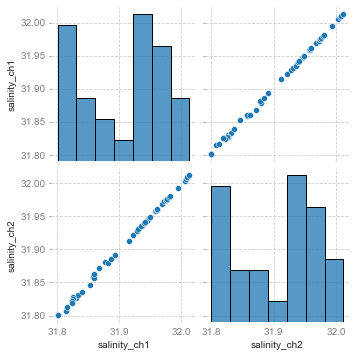

In [63]:
#cruise_data_nc.get_xdf().to_dataframe().columns
sns.pairplot(cruise_data_nc.to_dataframe()[['salinity_ch1', 'salinity_ch2',]])

In [ ]:
# ## Export data from nc files
# for cast in sorted(os.listdir(sample_data_dir+'working/')):
#     if cast.endswith('.nc'):
#         cruise_data_nc = xa.load_dataset(sample_data_dir+'working/'+cast)
#         cruise_data_nc.to_dataframe().to_csv(sample_data_dir+'working/'+cast.replace('.nc','.to_edit.csv') )